In [ ]:
from google.colab import drive
import os
import tensorflow as tf
from zipfile import ZipFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
drive.mount('/content/myDrive')

Mounted at /content/myDrive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/myDrive/My Drive/kaggleDataSet'
!kaggle datasets download -d moohsassin/fruits-and-vegetables

100% 6.55G/6.55G [02:17<00:00, 26.4MB/s]



In [ ]:
with ZipFile(os.path.join('/content', 'fruits-and-vegetables.zip'), 'r') as zip_file:
  file_name_list = zip_file.namelist()
  for file_name in file_name_list:
    if file_name.startswith(('dataSetLM/carambola/', 'dataSetLM/guava/', 'dataSetLM/pitaya/')):
      zip_file.extract(file_name, 'dataset')

base_dir = os.path.join('/content', 'dataset', 'dataSetLM')
print(os.listdir(base_dir))

['guava', 'carambola', 'pitaya']


In [ ]:
trainDataGenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

validationDataGenerator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)
 
train_gen = trainDataGenerator.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        batch_size=32,
        color_mode='rgb',
        seed=42,
        class_mode='categorical',
        shuffle=False,
        subset='training')
 
validation_gen = validationDataGenerator.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        batch_size=32,
        color_mode='rgb',
        seed=42,
        shuffle=False,
        class_mode='categorical',
        subset='validation')

Found 8447 images belonging to 3 classes.
Found 2110 images belonging to 3 classes.


In [ ]:
my_model = tf.keras.models.Sequential([
    Conv2D(16, (5,5), strides=(2,2), activation='relu', input_shape=(150, 150, 3)),
    ZeroPadding2D(padding=(1,1)),
    Conv2D(32, (3,3), strides=(2,2), activation='relu'),
    MaxPooling2D((2,2), strides=(2,2)),
    Conv2D(64, (3,3), strides=(1,1), activation='relu'),
    MaxPooling2D((2,2), strides=(1,1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 16)        1216      
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92:
      print('\nAkurasi dan Val_Akurasi berhasil mencapai >92%\n')

callback = myCallback()

In [ ]:
my_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

history = my_model.fit(
    train_gen,
    steps_per_epoch=train_gen.n // train_gen.batch_size,
    epochs=15,
    validation_data=validation_gen,
    validation_steps=validation_gen.n // validation_gen.batch_size,
    callbacks=[callback],
    verbose=1)

Epoch 1/15
263/263 [==============================] - 140s 527ms/step - loss: 1.0106 - accuracy: 0.5291 - val_loss: 1.0584 - val_accuracy: 0.4750
Epoch 2/15
263/263 [==============================] - 138s 524ms/step - loss: 0.7052 - accuracy: 0.6885 - val_loss: 0.1739 - val_accuracy: 0.9365
Epoch 3/15
263/263 [==============================] - 140s 530ms/step - loss: 0.3042 - accuracy: 0.8631 - val_loss: 0.1268 - val_accuracy: 0.9707
Epoch 4/15
263/263 [==============================] - 138s 525ms/step - loss: 0.2045 - accuracy: 0.9283 - val_loss: 0.0428 - val_accuracy: 0.9856

Akurasi dan Val_Akurasi berhasil mencapai >92%

Epoch 5/15
263/263 [==============================] - 138s 526ms/step - loss: 0.1711 - accuracy: 0.9403 - val_loss: 0.0614 - val_accuracy: 0.9808

Akurasi dan Val_Akurasi berhasil mencapai >92%

Epoch 6/15
263/263 [==============================] - 138s 523ms/step - loss: 0.1285 - accuracy: 0.9540 - val_loss: 0.0261 - val_accuracy: 0.9904

Akurasi dan Val_Akurasi b

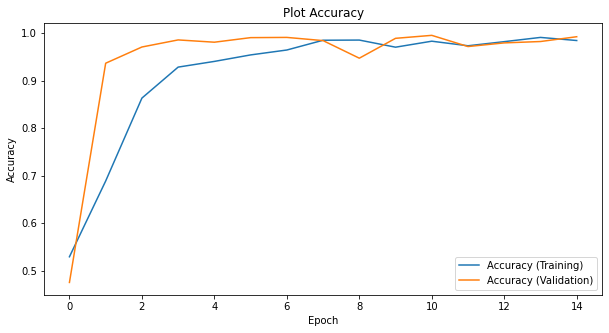

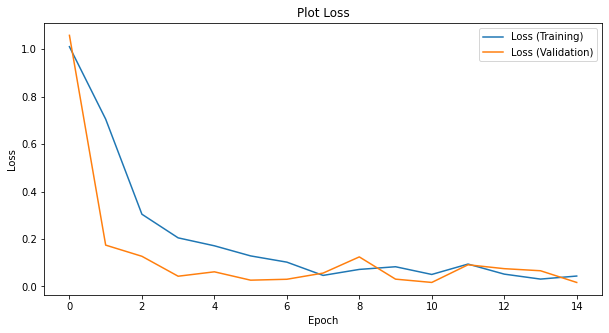

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.epoch, history.history['accuracy'], label='Accuracy (Training)')
plt.plot(history.epoch, history.history['val_accuracy'], label='Accuracy (Validation)')
plt.title('Plot Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.epoch, history.history['loss'], label='Loss (Training)')
plt.plot(history.epoch, history.history['val_loss'], label='Loss (Validation)')
plt.title('Plot Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
my_model.save('models/carambola_guava_pitaya_model.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

open('models/carambola_guava_pitaya_model.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpmadgds26/assets


3797056

Saving gambar.jpg to gambar.jpg


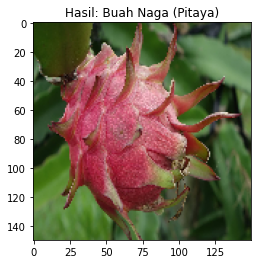

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  
  images = np.vstack([x])
  
  resultProb = my_model.predict(images)
  resultLabel = resultProb.argmax(axis=-1)
  
  if resultLabel == 0:
    plt.title('Hasil: Belimbing (Carambola)')
  elif resultLabel == 1:
    plt.title('Hasil: Jambu Biji (Guava)')
  elif resultLabel == 2:
    plt.title('Hasil: Buah Naga (Pitaya)')